# Lab 5_3 Convolutional Auto Encoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


In [2]:

# Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 905kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:

# Define Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder Layers
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)  # Output: (16, 14, 14)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # Output: (32, 7, 7)
        self.fc1 = nn.Linear(32 * 7 * 7, 16)
        self.fc2 = nn.Linear(16, 32 * 7 * 7)

        # Decoder Layers
        self.t_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)  # Output: (16, 14, 14)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)  # Output: (1, 28, 28)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return x

    def decode(self, x):
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 32, 7, 7)  # Reshape
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
        return x

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

In [4]:
# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [5]:

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)  # No flattening!

        outputs = autoencoder(images)  # Use existing model instance
        loss = criterion(outputs, images)  # Reconstruction loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete.")

Epoch [1/10], Loss: 0.0461
Epoch [2/10], Loss: 0.0394
Epoch [3/10], Loss: 0.0344
Epoch [4/10], Loss: 0.0345
Epoch [5/10], Loss: 0.0357
Epoch [6/10], Loss: 0.0353
Epoch [7/10], Loss: 0.0336
Epoch [8/10], Loss: 0.0401
Epoch [9/10], Loss: 0.0338
Epoch [10/10], Loss: 0.0332
Training complete.


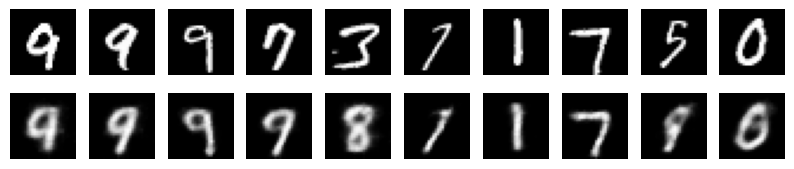

In [6]:
# Visualize Original and Reconstructed Images
images, _ = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    reconstructed = autoencoder(images)

images = images.cpu().view(-1, 28, 28)
reconstructed = reconstructed.cpu().view(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i], cmap='gray')
    axes[1, i].axis('off')
plt.show()